Before we get names, we need to be more sophisticated about which data is used to predict which Hallam Chase.
I will use 'seasons' i.e. 2017-2018, 2018-2019 etc. that start in June and end in May.
When I get race times, I will create a new column 'season' which will denote the starting year of that season. I.e. Season is 2018 if the 2018-2019 season.

In [ ]:
import pandas as pd
import sqlite3
import numpy as np
from pathlib import Path
from IPython.display import display
from IPython.core.display import HTML

from fellpace.analysis_tools import convert_Chase_ZScore_logs_avg
# Connect to the FellPace Database
db_file = "C:\\PythonProjects\\FellPace\\fellpace.db"
con = sqlite3.connect(db_file)

In [2]:
# For races with multiple results can return the Xth percentile of performance with this function
class XPercentile:
    percentile = 0.2
    def __init__(self):
        self.values = []

    def step(self, value):
        self.values.append(value)

    def finalize(self):
        self.values.sort()
        upper_quartile_index = round(self.percentile * (len(self.values)))-1
        return self.values[upper_quartile_index]
        #return self.values[0]


con.create_aggregate("XPercentile",1,XPercentile)

# Have to create custom STD DEV function as not in SQL LITE
import math
class std_dev:
    def __init__(self):
        self.n = 0
        self.sum = 0
        self.sq = 0

    def step(self, value):
        self.n += 1
        self.sum += value
        self.sq += value * value

    def finalize(self):
        return math.sqrt(self.sq/self.n - (self.sum/self.n * self.sum/self.n )  )
    
con.create_aggregate('stddev',1,std_dev)

In [3]:
sql_extract_zscore = '''WITH Chase_Yrs AS
(
    SELECT Racer_ID, 
           CAST(strftime("%Y",CD.Chase_Date) AS INTEGER) - 1 as Season,
           ZScore_log
    FROM Results_Chase
    JOIN Chases as CD
    ON CD.Chase_ID = Results_Chase.Chase_ID
),

Racers_Results AS
(
    SELECT Racer_ID, ZScore_log, Race_ID, Time
    FROM Results
    
),

Races_Rename AS
(
    SELECT CASE
    WHEN Race_Name LIKE "Parkrun_endcliffe%" THEN "PR_Endcliffe"
    WHEN Race_Name LIKE "Parkrun_hillsborough%" THEN "PR_Hillsborough"
    ELSE Race_Name
    END            AS Race_Name,
    CASE
        WHEN CAST(strftime("%m",Race_Date) AS INTEGER) > 5
        THEN CAST(strftime("%Y",Race_Date) AS INTEGER)
        ELSE CAST(strftime("%Y",Race_Date) AS INTEGER) -1
    END AS Season,
    Race_ID
    FROM   Races
),
Results_joined AS
(
    SELECT Racer_ID, C.Race_Name, C.Season, XPercentile(ZScore_log) as ZScore, C.Race_ID
    FROM Racers_Results
    LEFT JOIN Races_Rename as C
    ON C.Race_ID = Racers_Results.Race_ID
    WHERE Time IS NOT NULL
    GROUP BY Racer_ID, C.Race_Name, C.Season
)


SELECT R.Racer_ID,R.Race_Name, R.Season, R.ZScore, HC.ZScore_log as HCScore
FROM Results_joined as R
LEFT JOIN Chase_Yrs as HC
ON HC.Racer_ID = R.Racer_ID
AND HC.Season = R.Season
WHERE R.Racer_ID IN (SELECT Racer_ID FROM Results_Chase)
AND HCScore IS NOT NULL'''

data_Zs = pd.read_sql(sql_extract_zscore,con)
data_Zs.sort_values('Race_Name',inplace=True)

In [4]:
# Drop poor race series
data_Zs = data_Zs.drop(data_Zs[data_Zs['Race_Name'] == 'Bamford Sheep Dog Trials'].index,axis=0)
data_Zs = data_Zs.drop(data_Zs[data_Zs['Race_Name'] == 'Eyam Fell Race'].index,axis=0)
data_Zs = data_Zs.drop(data_Zs[data_Zs['Race_Name'] == 'Tideswell Wakes'].index,axis=0)
data_Zs = data_Zs.drop(data_Zs[data_Zs['Race_Name'] == 'Bakewell Pudding'].index,axis=0)

In [5]:
# Experiment with filtering data with a Ransac regressor
from sklearn import linear_model
#get test dataset
def find_inliers(group):
    X = group.ZScore.values.reshape([-1,1])
    y = group.HCScore.values.reshape([-1,1])
    ransac = linear_model.RANSACRegressor()
    ransac.fit(X,y)
    
    return pd.Series(ransac.inlier_mask_)

data_Zs['inlier'] = data_Zs.groupby('Race_Name',group_keys=False,sort=True,as_index=False).apply(find_inliers).values


c:\Users\wired\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


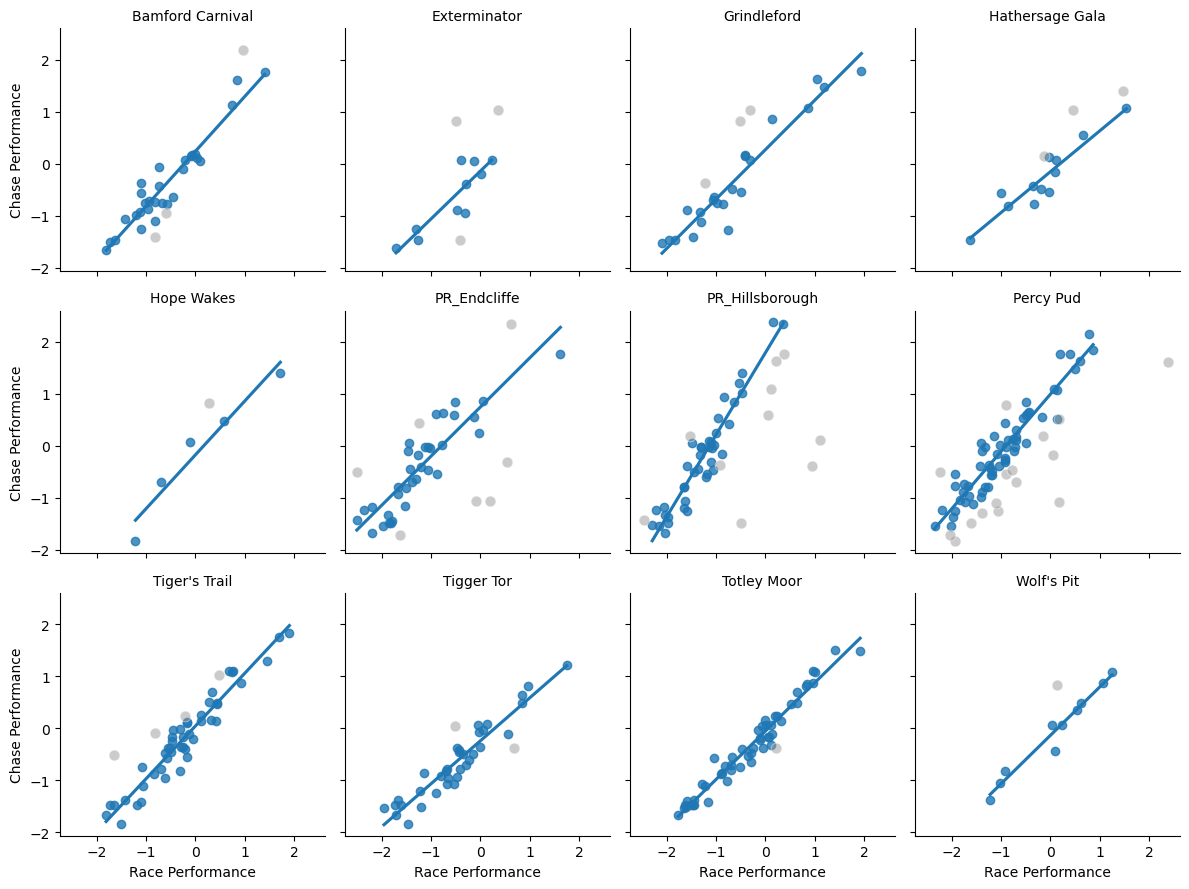

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
# Plotting Check
def plot_inlier_outlier(x,y,inlier,**kwargs):
    x_in = x.loc[inlier == True]
    y_in = y.loc[inlier == True]
    
    x_out = x.loc[inlier == False]
    y_out = y.loc[inlier == False]
    sns.regplot(x=x_in,y=y_in,ci=0)
    sns.scatterplot(x=x_out,y=y_out,s=60,color=[0.6,0.6,0.6],alpha=0.5).set(xlabel='Race performance',ylabel='Chase performance')
    
g = sns.FacetGrid(data=data_Zs,col='Race_Name',col_wrap=4).set_titles("{col_name}")
g.map(plot_inlier_outlier,"ZScore","HCScore","inlier")
g.set_xlabels('Race Performance').set_ylabels('Chase Performance')
plt.show()

The coefficients will be used to predict the performance of new competitors

In [7]:

coeffs = data_Zs.groupby('Race_Name').apply(lambda x: np.polyfit(x['ZScore'],x['HCScore'],1))

def seconds_to_time_string(run_times: np.ndarray):
    run_times_strings = []
    for run_time in run_times:
        seconds = divmod(run_time,60)[1]
        minutes_t = divmod(run_time,60)[0]
        hours = divmod(minutes_t,60)[0]
        minutes = divmod(minutes_t,60)[1]
        run_times_strings.append(f"{hours:02.0f}:{minutes:02.0f}:{seconds:02.0f}")
    return run_times_strings

# Create a function that will take in a name and export a dictionary of results (or a result object)
def get_predicted_time(coeffs: pd.DataFrame,name: str, season: int=-1)->pd.DataFrame:
    #Only filter by season if one provided
    if season == -1:
        season_filter = ""
    else:
        season_filter = "AND Season = ?"
    query = f"""
    WITH Racers_Results AS
    (
        SELECT Racer_ID, ZScore_log, Race_ID, Time
        FROM Results
    ),

    Races_Rename AS
    (
        SELECT CASE
        WHEN Race_Name LIKE "Parkrun_endcliffe%" THEN "PR_Endcliffe"
        WHEN Race_Name LIKE "Parkrun_hillsborough%" THEN "PR_Hillsborough"
        ELSE Race_Name
        END  AS Race_Name,
        CASE
            WHEN CAST(strftime("%m",Race_Date) AS INTEGER) > 5
            THEN CAST(strftime("%Y",Race_Date) AS INTEGER)
            ELSE CAST(strftime("%Y",Race_Date) AS INTEGER) -1
        END AS Season,
        Race_ID
        FROM   Races
    ),
    Results_joined AS
    (
        SELECT Racer_ID, C.Race_Name, C.Season, XPercentile(ZScore_log) as ZScore, C.Race_ID
        FROM Racers_Results
        LEFT JOIN Races_Rename as C
        ON C.Race_ID = Racers_Results.Race_ID
        WHERE Time IS NOT NULL
        GROUP BY Racer_ID, C.Race_Name, C.Season
    )

    SELECT R.Racer_ID,R.Race_Name, R.Season, R.ZScore
    FROM Results_joined as R
    WHERE Racer_ID = ?
    {season_filter}
    """
    
    get_racer_ID = """
    SELECT * FROM Racers
    WHERE lower(Racer_Name) = ?
    """
    # Convert name to lower case so easy to match
    name = name.lower()
    racer_match = pd.read_sql(get_racer_ID,con,params=(name,))
    if racer_match.empty:
        return pd.DataFrame()
    racer_ID = racer_match["Racer_ID"].values[0]
    # Prepare parameters to query
    if season == -1:
        query_params = (str(racer_ID),)
    else:
        query_params = (str(racer_ID),season)
    racer_results = pd.read_sql(query,con,params = query_params)
    if racer_results.empty:
        # They are in the database but haven't run in the last season
        return pd.DataFrame()
    racer_results['PredZ'] = racer_results.apply(lambda x: np.polyval(coeffs[x['Race_Name']],x['ZScore']),axis=1)
    racer_results['Predicted Time'] = convert_Chase_ZScore_logs_avg(con,racer_results['PredZ'])
    racer_results['Racer_Name'] = name
    #Re-order the columns
    return racer_results[['Racer_Name','Race_Name','Season','ZScore','Predicted Time']]

get_predicted_time(coeffs,"Mark Prince",2022)

,Racer_Name,Race_Name,Season,ZScore,Predicted Time
0,mark prince,Grindleford,2022,-2.063925,1507.620345
1,mark prince,PR_Endcliffe,2022,-1.921741,1651.874529
2,mark prince,PR_Hillsborough,2022,0.291744,2277.012683
3,mark prince,Percy Pud,2022,-1.958768,1621.262154


In [8]:
def axis_time(seconds_in,pos):
    seconds = divmod(seconds_in,60)[1]
    minutes = divmod(seconds_in,60)[0]
    hours = divmod(minutes,60)[0]
    return f"{minutes:02.0f}:{seconds:02.0f}"

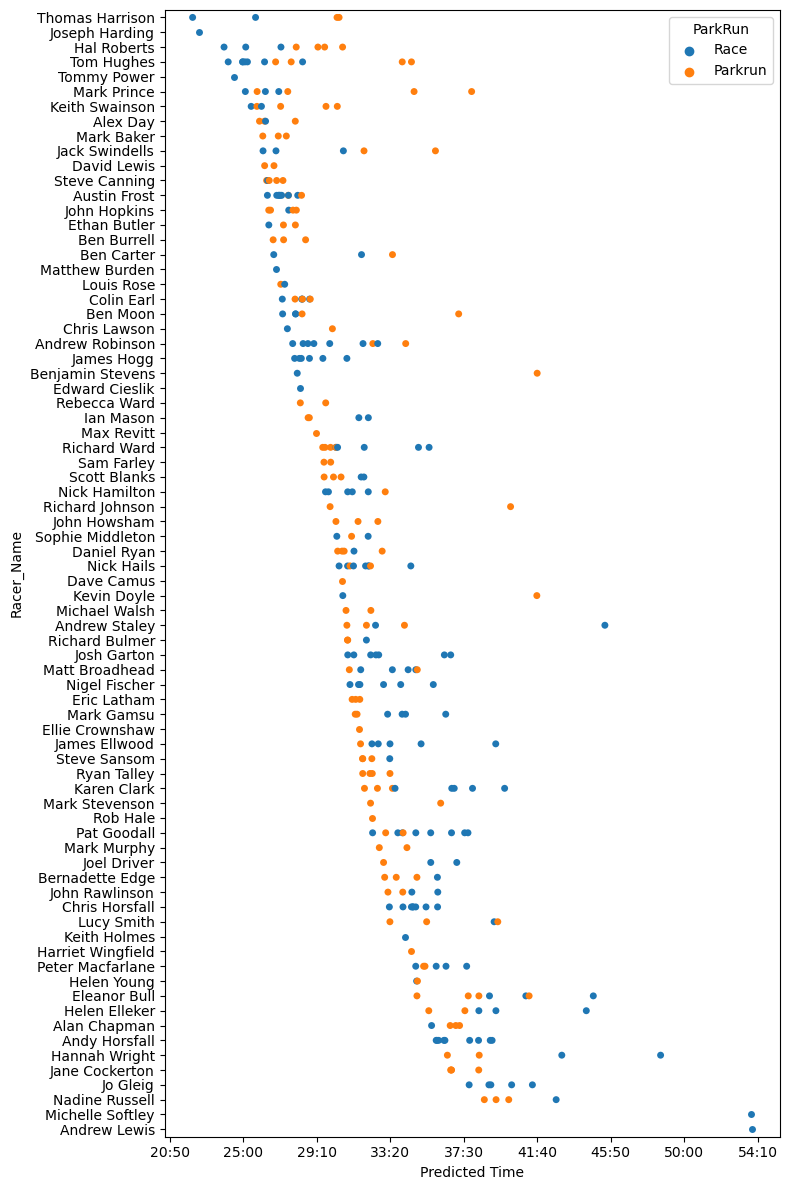

In [57]:
a4_dims = (8, 12)
fig, ax = plt.subplots(figsize=a4_dims)
# Go through names and get dataframes from each
# Get last two years to bolster data
entries_file = Path(r"Entries/entries_18.5.24")
predictions = pd.DataFrame()
with open(entries_file) as entries:
    for entry in entries:
        entry = entry.rstrip()
        predictions = pd.concat([predictions,get_predicted_time(coeffs,entry,2023)])
        predictions = pd.concat([predictions,get_predicted_time(coeffs,entry,2022)])
# Sort the results
predictions = predictions.sort_values(['Racer_Name','Season','Race_Name'])
# Change names to title case
predictions['Racer_Name'] = predictions['Racer_Name'].str.title()
predictions['ParkRun'] = predictions['Race_Name'].str.contains("PR").replace({True:'Parkrun',False:'Race'})


f= sns.stripplot(jitter=False,ax=ax,data = predictions.sort_values(['Predicted Time']), x = "Predicted Time", y = "Racer_Name",hue='ParkRun')
ax = plt.gca()
ax.xaxis.set_major_formatter(axis_time)
plt.tight_layout()
f.get_figure().savefig("predictions.png") 

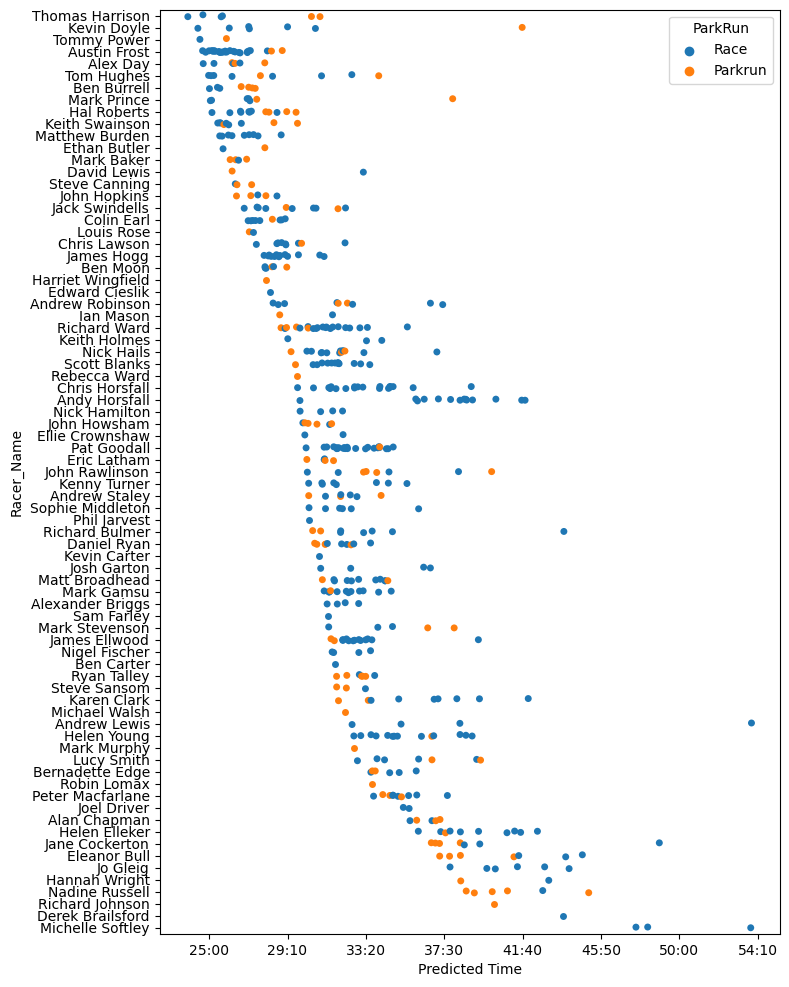

In [10]:
# Go through and get any other data without a season "Second Tier predictions"
a4_dims = (8, 12)
fig, ax = plt.subplots(figsize=a4_dims)
predictions_other = pd.DataFrame()
with open(entries_file) as entries:
    for entry in entries:
        entry = entry.rstrip()
        predictions_other = pd.concat([predictions_other,get_predicted_time(coeffs,entry)])
# Get rid of 2023 data
predictions_other = predictions_other.loc[predictions_other['Season'] != 2023]
predictions_other = predictions_other.sort_values(['Racer_Name','Season','Race_Name'])
predictions_other['Racer_Name'] = predictions_other['Racer_Name'].str.title()
predictions_other['ParkRun'] = predictions_other['Race_Name'].str.contains("PR").replace({True:'Parkrun',False:'Race'})
f= sns.stripplot(data = predictions_other.sort_values(['Predicted Time']), x = "Predicted Time", y = "Racer_Name",hue='ParkRun')
ax = plt.gca()
ax.xaxis.set_major_formatter(axis_time)
f.get_figure().savefig("predictions_other.png") 


In [11]:
def format_time(group):
    group = group.sort_values(["Predicted Time"],ascending=True)
    group = group.reset_index(drop=True)
    group.index = group.index.map(lambda x: f"{x+1:02d}")
    
    grouped = pd.DataFrame()
    grouped["Racer Name"] = group["Racer_Name"]
    grouped["RaceTime"] = group["Race_Name"] + " ("+group['Season'].astype('str')+"): " + seconds_to_time_string(group["Predicted Time"])
    grouped["Race"] = "Race " + group.index.astype('str')
    return grouped

# Prepare predictions for better Excel formatting
# Sort
BestTimes = predictions.groupby("Racer_Name")["Predicted Time"].min().reset_index()
predictions_export = predictions.groupby("Racer_Name",as_index=False,sort=False).apply(format_time).pivot(index="Racer Name",columns="Race",values="RaceTime")
predictions_export = pd.merge(predictions_export,BestTimes,left_on="Racer Name",right_on="Racer_Name").sort_values("Predicted Time").drop("Predicted Time",axis=1)

# Prepare predictions for better Excel formatting
# Sort
BestTimes_other = predictions_other.groupby("Racer_Name")["Predicted Time"].min().reset_index()
predictions_other_export = predictions_other.groupby("Racer_Name",as_index=False,sort=False).apply(format_time).pivot(index="Racer Name",columns="Race",values="RaceTime")
predictions_other_export = pd.merge(predictions_other_export,BestTimes_other,left_on="Racer Name",right_on="Racer_Name").sort_values("Predicted Time").drop("Predicted Time",axis=1)



In [58]:
# Load in the results
results = pd.read_csv('Entries/2024/results.csv')
results['name'] = results['Forename'] + ' ' + results['Surname']
results = results[['name','Actual Time','Off Time']]
predictions = predictions.groupby("Racer_Name",as_index=False,sort=False).apply(format_time)


In [59]:
def timestr_tosec(timestrs: pd.Series):
    elements = []
    for timestr in timestrs:
        timeparts = str.split(timestr,':')
        multipliers = [3600,60,1]
        timesecs = 0
        while len(timeparts) > 0:
            timesecs += int(timeparts.pop()) * multipliers.pop()
        elements.append(timesecs)
    return pd.Series(elements)

In [60]:
predictions = predictions.merge(results,how='left',left_on='Racer Name',right_on='name')

In [63]:
predictions['error'] = predictions['RaceTime'].str.split(':',n=1).str[1] - timestr_tosec(predictions['Actual Time'])

TypeError: descriptor 'split' for 'str' objects doesn't apply to a 'float' object

In [53]:
predictions['RaceTime'].str.split(':',n=1).str[1]



0       00:35:41
1       00:36:44
2       00:37:03
3       00:37:16
4       00:25:56
         ...    
317     00:27:43
318     00:28:22
319     00:34:01
320     00:34:32
321     00:24:30
Name: RaceTime, Length: 322, dtype: object